In [1]:
import nrrd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import cv2
import scipy

import SimpleITK as sitk 

#/mnt/d/SimpsonLab/


# def read_mha_metadata(file_path):
#     # Read the image using SimpleITK
#     image = sitk.ReadImage(file_path)

#     # Get the metadata keys
#     metadata_keys = image.GetMetaDataKeys()

#     # Create a dictionary to store the metadata
#     metadata = {}

#     # Iterate through the metadata keys and get the corresponding values
#     for key in metadata_keys:
#         metadata[key] = image.GetMetaData(key)

#     return metadata

baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE244'
segmentFilePath = baseFilepath + '/CASE244_BASE_PRT_TUM_CV.seg.nrrd'
wholeFilePath = baseFilepath + '/CASE244_BASE_PRT_WHOLE_CT.nrrd' 

segment, segmentHeader = nrrd.read(segmentFilePath)
whole, wholeHeader = nrrd.read(wholeFilePath)

# segmentOriginal = sitk.ReadImage(segmentFilePath)
# wholeOriginal = sitk.ReadImage(wholeFilePath)
# for k in segmentOriginal.GetMetaDataKeys():
#     v = segmentOriginal.GetMetaData(k)
#     print(f'({k}) = = "{v}"')


# print(segmentOriginal)
print("==================Whole Header===================")
for key, value in wholeHeader.items():
    print(f"{key}:{value}")


print("==================Segmented Header===================")
for key, value in segmentHeader.items():
    print(f"{key}:{value}")



==================Whole Header===================
type:short
dimension:3
space:left-posterior-superior
sizes:[512 512 135]
space directions:[[0.902344 0.       0.      ]
 [0.       0.902344 0.      ]
 [0.       0.       2.5     ]]
kinds:['domain', 'domain', 'domain']
endian:little
encoding:raw
space origin:[-231.  -216.6 -490. ]
0008|0005:ISO_IR 100
0008|0008:ORIGINAL\\PRIMARY\\AXIAL
0008|0012:20180104
0008|0013:162415
0008|0016:1.2.840.10008.5.1.4.1.1.2
0008|0018:1.2.840.113619.2.340.3.2743887939.697.1515062072.113.166
0008|0020:20180104
0008|0021:20180104
0008|0022:20180104
0008|0023:20180104
0008|0030:160949
0008|0031:161734
0008|0032:162140.007732
0008|0033:162415
0008|0050:519017
0008|0060:CT
0008|0070:GE MEDICAL SYSTEMS
0008|1030:CT ANGIO PANCREAS WITH CH/PEL
0008|103e:PV 2.5mm
0008|1090:Discovery CT750 HD
0008|3010:1.2.840.113619.2.340.3.2743887939.697.1515062071.987
0010|0010:RIA_22-194_000001
0010|0020:RIA_22-194_000_000001
0010|0030:19000101
0010|4000:Project: 22-194; Subject

In [2]:
# Normalize the whole image (get rid of HU index of air, and normalize voxel size)
def tranform_to_hu(image, intercept, rescale):
    return image * rescale + intercept

# Normalize the spacing of the whole image to isomorphic voxel size 1mm^3 
def resample_spacing(image, current_spacing, ideal_spacing = [[1,0,0],[0,1,0],[0,0,1]]):
    if np.array_equal(current_spacing,ideal_spacing):
        return image 

    resize_factor = np.array(current_spacing) / np.array(ideal_spacing)
    new_shape = np.round(image.shape * resize_factor) 
    new_resize_factor = np.array(new_shape) / np.array(image.shape)
    
    new_spacing = current_spacing / new_resize_factor

    new_resize_factor = [new_resize_factor[0][0], new_resize_factor[1][1], new_resize_factor[2][2]] # convert to a 1x3 list to avoid error for zoom function
    print(new_resize_factor)
    # Works but is slow
    image = scipy.ndimage.zoom(image, new_resize_factor, mode='nearest', order = 0) #nearest

    # Something with matlab, haven't tested    
    # image = imresize(image, new_resize_factor) #nearest 
    new_spacing = formatSpaceDirection(new_spacing)
    return image, new_spacing 


def window_image_to_adbomen(image, window_center, window_width):
    # image = sitk.GetArrayFromImage(image)
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def formatSpaceDirection(spaceDirection):
    return np.array( [spaceDirection[0][0], spaceDirection[1][1], spaceDirection[2][2]]) 

def check_alignment(imageData, segmentData):
    """ A list of 3 elements, the space dimension, the space, and the space origin. Checks if the images are the same between each one"""
    if not np.array_equal( imageData[0], segmentData[0]):
        print("The space dimension is not the same")
        return False
    if imageData[1] != segmentData[1]:
        print('The space direction is not the same')
        return False
    if not np.array_equal(imageData[2],segmentData[2]):
        print('The space origin is not the same')
        return False

    return True
    

    

C:\Users\johnz\AppData\Local\Temp\ipykernel_18156\686636324.py:10: RuntimeWarning: invalid value encountered in divide
  resize_factor = np.array(current_spacing) / np.array(ideal_spacing)


[0.90234375, 0.90234375, 2.5037037037037035]
[0.90234375, 0.90234375, 2.5037037037037035]
[1.00000028 1.00000028 0.99852071]
[1.00000028 1.00000028 0.99852071]
Whole and Image are aligned: True
(462, 462, 338)
# of Segmented slices :43
Segmented slices :[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172]


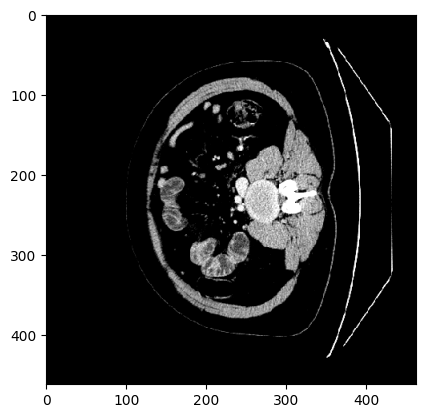

In [10]:
#Grab information about the spacing and the pixels of the whole image and the segment
whole_spacing = wholeHeader['space directions'] 
whole_space = wholeHeader['space']
whole_space_origin = wholeHeader['space origin']

segment_spacing = segmentHeader['space directions'] 
segment_space = segmentHeader['space']
segment_space_origin = segmentHeader['space origin']


use_hu = wholeHeader['0028|1054'] == 'HU' # States if the image is in HU units
hu_intercept = wholeHeader['0028|1052'] 
hu_rescale = wholeHeader['0028|1053']

# Grab information about the spacing of the pixels of the segmented image 

segment_spacing = segmentHeader['space directions'] 
# Windowing parameters for the abdomen
ABDOMEN_UPPER_BOUND = 215
ABDOMEN_LOWER_BOUND = -135
window_center = (ABDOMEN_UPPER_BOUND+ABDOMEN_LOWER_BOUND) / 2
window_width = (ABDOMEN_UPPER_BOUND-ABDOMEN_LOWER_BOUND) / 2

# Window and resample the whole image
augmented_whole = window_image_to_adbomen(whole, window_center, window_width)
augmented_whole, whole_spacing = resample_spacing(augmented_whole, whole_spacing)

# Resample the segment image to the same spacing as the whole image
augmented_segment = segment
augmented_segment, segment_spacing = resample_spacing(augmented_segment, segment_spacing)

print(whole_spacing)
print(segment_spacing)

print('Whole and Image are aligned:', check_alignment([whole_spacing, whole_space, whole_space_origin], [segment_spacing, segment_space, segment_space_origin]))


print(augmented_whole.shape)
plt.imshow(augmented_whole[:, :, 53], cmap="gray")

# Get the slice indices where the segment is present in 
segmentedSlices = [] 
for index in range(augmented_segment.shape[-1]):
    if len(np.unique(augmented_segment[:,:,index])) > 1:
        segmentedSlices.append(index)
print(f"# of Segmented slices :{len(segmentedSlices)}")
print(f"Segmented slices :{segmentedSlices}")


Preprocessing aimed to subtract the segmentation from the whole image

(462, 462, 338)
CroppedSegment shape: (50, 50, 42)


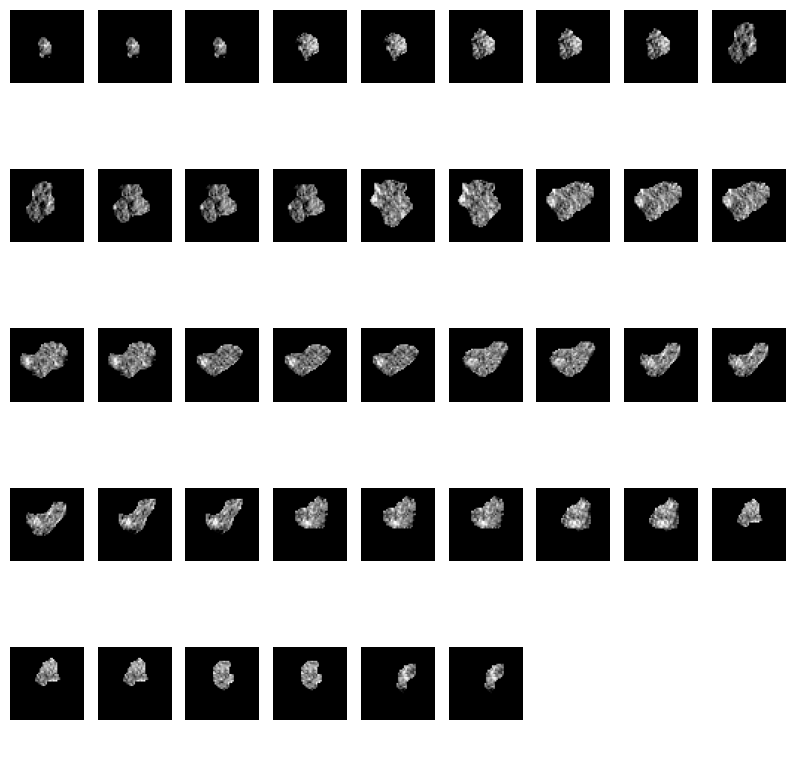

In [22]:
overlay_segment = np.multiply(augmented_whole,augmented_segment)
print(overlay_segment.shape)

# print("Dimension of the CT scan is:", image.shape)
# plt.imshow(overlay_segment[:, :, 133], cmap="gray")

ROWLEN = 5
COLUMNLEN = 9
figure,axis = plt.subplots( ROWLEN, COLUMNLEN, figsize=(10, 10))
n = len(segmentedSlices)


def centerXYOfImage(images, segmentedSlices, padding=50):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    x_indices, y_indices, z_indices = np.where(images == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2
    
    # Get the dimensions of the cropped image
    start_x = max(0, center_x - padding)
    end_x = min(images.shape[0], center_x + padding)
    start_y = max(0, center_y - padding)
    end_y = min(images.shape[1], center_y + padding)

    segmentedSlices = np.sort(np.array(segmentedSlices))

    return images[start_x:end_x, start_y:end_y, segmentedSlices[0]:segmentedSlices[len(segmentedSlices)-1]]
        
croppedSegment = centerXYOfImage(overlay_segment,segmentedSlices,25)
# croppedSegment = window_image_to_adbomen(croppedSegment, window_center, window_width)
croppedSegment[croppedSegment<0]=0 # Window the image so that the background is completely black for all slices

print(f'CroppedSegment shape: {croppedSegment.shape}')
# Display the segmented image slices 
rowIdx = 0
for idx in range(croppedSegment.shape[-1]):        
    if idx%COLUMNLEN == 0 and idx>0:
        rowIdx += 1
    axis[rowIdx][idx%COLUMNLEN].imshow(croppedSegment[:,:,idx], cmap="gray")
    axis[rowIdx][idx%COLUMNLEN].axis('off')

# Turn off the axis of the rest of the subplots
for i in range(idx, ROWLEN*COLUMNLEN):
    axis[rowIdx][i%COLUMNLEN].axis('off')

plt.show()

Perform this on all pre-treatment images available


In [24]:
"""
Confirm that the pre- and post- folders are different and have no correlation in naming conventions
"""
import os 
postFolder = 'PDAC-Response/PDAC-Response/ImagingData/Post-treatment'
preFolder = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment'

numbers = []
for folder in os.listdir(preFolder):
    if 'empty' in folder:
        continue
    number = folder[-3:] 
    numbers.append(number)

successes = 0

for folder in os.listdir(postFolder):
    if 'no segmentation' in folder:
        continue
    number = folder[-3:] 
    # print(number)
    if number in numbers:
        successes += 1 

print(f'# of values that have the same prefix for pre and post treatment: {successes}')

    

# of values that have the same prefix for pre and post treatment: 0


In [25]:
import pandas as pd

columns = (
'CaseID_inSharedFolder','SubstituteIDs_forMRN','TumorSegmented','Sex','Age','BMI','PerformStat_ECOG','DM','PerformStat_WHO','Preop_AST_ALT_ratio','Preop_Total_Bili','Preop_Platelet','Preop_AST','Preop_ALT',
'Preop_INR',	
'Preop_Weight', 
'loss',	
'Preop_Creatinine',	
'CA19-9_Baseline',
'CA19.9 postNAC',
'CA19-9_Preop',
'CA19-9_Nadir',
'PreNAC_Bil_Obstrct',
'PreNAC_Bil_Drainage',
'Baseline_Resectablty',
'Resected',
'Resection_Type',
'Art_Invlmnt',
'Vein_Invlmnt',
'Venous_Resec',
'Venous_Resec_Type',
'Art_Resec',
'Art_Resec_Type',
'Resect_Margin',
'R1_Status',
'Path_Diff',
'Tumor_Loc',
'Tumor_Size_PreNAC',
'Tumor_Size_PostNAC',
'Tumor_Size_PostNAT',
'RECIST_PostNAT',
'Eval_PostNAT',
'T_Stage',
'N_Stage',
'Tum_Clinic_Stage',
'numberLN_Examined',
'numberLN_Involved',
'Pos_LNs_Ratio',
'LVI',
'PNI',
'TxEffect_Percent',
'Neoadj_Chemo',
'Neoadj_Chemo-Rigem_Name',
'Neoadj_Chemo-Rigem_Coded',
'Neoadj_Chemo_CycleNo',
'Chemo_RTx',	
'Chemo_RTx_RegName',	
'RTx_postNAC',	
'Nadj_RadTx',	
'Nadj_RadTx_Type',	
'Nadj_RadTx_FracNo',	
'Nadj_RadTx_TotalGy',	
'Adj_Chemo',	
'Adj_Chemo_Regim	',
'Adj_Chemo_Cycle',	
'PostOp_Holiday',	
'OS_fromDx',	
'OS_fromSurg',
'RFS_fromDx',
'RFS_fromSurg',
'Recrnc-Prgrss_Loc')

data = pd.read_excel('PDAC-Response_forExtCollab_Updated-2024-06-04.xlsx', 'Dataset_forAnalysis_ExtCollab', header=None,names = columns)
data.head()
# lol = data['CaseID_inSharedFolder']
# print(lol)

,CaseID_inSharedFolder,SubstituteIDs_forMRN,TumorSegmented,Sex,Age,BMI,PerformStat_ECOG,DM,PerformStat_WHO,Preop_AST_ALT_ratio,...,Nadj_RadTx_TotalGy,Adj_Chemo,Adj_Chemo_Regim\t,Adj_Chemo_Cycle,PostOp_Holiday,OS_fromDx,OS_fromSurg,RFS_fromDx,RFS_fromSurg,Recrnc-Prgrss_Loc
0,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,NaN
1,CaseID_inSharedFolder,SubstituteIDs_forMRN,TumorSegmented,Sex,Age,BMI,PerformStat_ECOG,DM,PerformStat_WHO,Preop_AST_ALT_ratio,...,Adj_Chemo,Adj_Chemo_Regim,Adj_Chemo_Cycle,PostOp_Holiday,OS_fromDx,OS_fromSurg,RFS_fromDx,RFS_fromSurg,Recrnc-Prgrss_Loc,NaN
2,546226,100001,1,1,68.054795,32.158934,0,NaN,NaN,NaN,...,-999,-999,-999,-999,13.233333,-999,9.766667,-999,liver+peritoneum+local POD,NaN
3,546227,100002,1,1,70.449315,31.885916,1,NaN,NaN,NaN,...,-999,-999,-999,-999,48.633333,-999,12.5,-999,NaN,NaN
4,546228,100003,0,0,60.30411,22.3,1,NaN,NaN,NaN,...,0,-111,-111,-111,18.166667,16.966667,7.533333,1.933333,liver,NaN


'which' is not recognized as an internal or external command,
operable program or batch file.


In [73]:
import os 
justPostCaseIDs = pd.Series(data['CaseID_inSharedFolder']).to_list()[2:]
print('=======Cases from the xsxl file==============')
print(justPostCaseIDs)
print(f'# of ids in xsxl:{len(justPostCaseIDs)}')

print('--- IDs with unmatched NACT CTs ---')
for case in justPostCaseIDs:
    if '546' not in str(case):
        print(case)

postFolder = 'PDAC-Response/PDAC-Response/ImagingData/Post-treatment'
folders = []
print('Folders that have \'no segmentation\' in the name in the post-treatment folder: ')
for folder in os.listdir(postFolder):
    if 'no segmentation' in folder:
        # continue
        folder = folder.replace('no segmentation', '')
        print(folder)
    folders.append(int(folder)) 


print('After further checking, 546228, 546141, 546142 are correct; the other ones are marked with 1 for \'tumor segmented\' but currently do not have the segmentation\n')

printData = data[['CaseID_inSharedFolder', 'TumorSegmented']]
print(printData.loc[printData['CaseID_inSharedFolder'] == 546141])

print(printData.loc[printData['CaseID_inSharedFolder'] == 546142])

print(printData.loc[printData['CaseID_inSharedFolder'] == 546165])

print(printData.loc[printData['CaseID_inSharedFolder'] == 546175])

print(printData.loc[printData['CaseID_inSharedFolder'] == 546180])

print(printData.loc[printData['CaseID_inSharedFolder'] == 546228])

print('=================================================================\n\n')
print(f'# of folders in post-treatment folder: {len(folders)}')
print('=======Cases in the post-treatment folder that are not in the csv==============')
successes=0
for folder in folders:
    if folder in justPostCaseIDs:
        successes+=1 
    else:   
        print(folder)
print(f'# of folders that are in both xsxl and the post-treatment folder: {successes} (92 should be correct)')

=======Cases from the xsxl file==============
[546226, 546227, 546228, 546229, 546230, 546231, 546232, 546233, 546234, 546140, 546141, 546142, 546143, 546144, 546145, 546146, 546147, 546148, 546149, 546150, 546151, 546152, 546153, 546154, 100025, 546156, 546157, 546158, 546159, 546160, 546161, 546162, 546163, 100034, 546165, 546166, 546167, 546168, 546169, 546170, 546171, 546172, 546173, 546174, 546175, 546176, 546177, 546178, 546179, 546180, 546181, 546182, 546183, 546184, 546185, 546186, 546187, 546188, 546189, 546190, 546191, 546192, 546193, 546194, 100065, 546196, 546197, 546198, 546199, 546200, 546201, 546202, 546203, 546204, 546205, 546206, 546207, 546208, 546209, 546210, 100081, 546211, 546212, 546213, 546214, 546215, 546216, 546217, 546218, 546219, 546220, 546221, 546222, 546223, 546224, 100096, 546225]
# of ids in xsxl:97
--- IDs with unmatched NACT CTs ---
100025
100034
100065
100081
100096
Folders that have 'no segmentation' in the name in the post-treatment folder: 
546141 